In [1]:
import pandas as pd
import plotly
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import holidays

from neuralprophet import NeuralProphet
from prophet import Prophet
from prophet.serialize import model_to_json
from sklearn.model_selection import ParameterGrid
from tqdm import tqdm

import sys
import os

backend_path = os.path.abspath('../backend')
sys.path.append(backend_path)
from get_metrics import get_metrics

# Количество предсказанных дней
pred_days_forecast = 180

Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.


In [2]:
# Чтение DataFrame df в файл data/df.csv
df = pd.read_csv('../data/df.csv')

# Чтение DataFrame df_train в файл data/df_train.csv
df_train = pd.read_csv('../data/df_train.csv')

# Чтение DataFrame df_test в файл data/df_test.csv
df_test = pd.read_csv('../data/df_test.csv')

In [3]:
# Преобразование столбца ds в формат datetime
df['ds'] = pd.to_datetime(df['ds'], format='%Y-%m-%d', dayfirst=True)
df_train['ds'] = pd.to_datetime(df_train['ds'], format='%Y-%m-%d', dayfirst=True)
df_test['ds'] = pd.to_datetime(df_test['ds'], format='%Y-%m-%d', dayfirst=True)

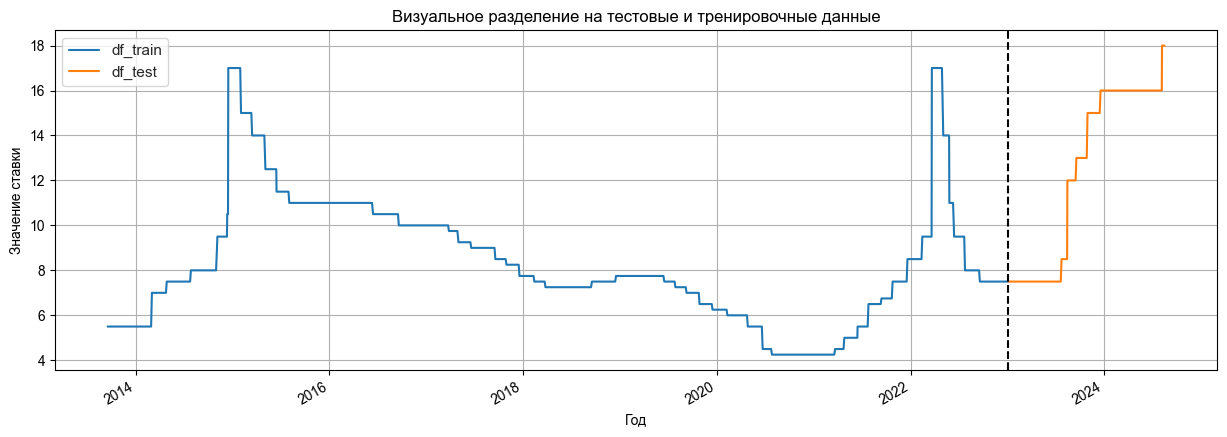

In [4]:
# Отображаем график с разделением train, test для наглядности
fig, ax = plt.subplots(figsize = (10, 5))

sns.set_theme(style="whitegrid", palette="Accent")

fig.set_figheight(5)
fig.set_figwidth(15)
df_train.set_index('ds').plot(ax=ax, label= 'train', title='Визуальное разделение на тестовые и тренировочные данные')
df_test.set_index('ds').plot(ax=ax, label='test')
ax.axvline(df_train['ds'][-1:].values, ls='--', color='black')
ax.legend(['df_train', 'df_test'])
ax.set_ylabel('Значение ставки')
ax.set_xlabel('Год')
plt.show()

# Baseline Prophet on df_train для проверки модели

In [5]:
# Обучение модели на train
model_baseline = Prophet()
model_baseline.fit(df_train)

00:07:44 - cmdstanpy - INFO - Chain [1] start processing
00:07:45 - cmdstanpy - INFO - Chain [1] done processing


In [6]:
# Период, который надо отрезать и предсказать (проверка модели)
pred_days = int(df.shape[0]*0.15)

In [7]:
# Создание df с прогнозом
future = model_baseline.make_future_dataframe(periods=pred_days, freq='D')
forecast = model_baseline.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
2717,2024-02-13,14.418498,12.299774,16.617032
2718,2024-02-14,14.434215,12.258744,16.573898
2719,2024-02-15,14.417058,12.388840,16.488999
2720,2024-02-16,14.427382,12.141070,16.695734
2721,2024-02-17,14.964852,12.747322,17.188544


WARNING - (py.warnings._showwarnmsg) - c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()

WARNING - (py.warnings._showwarnmsg) - c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',



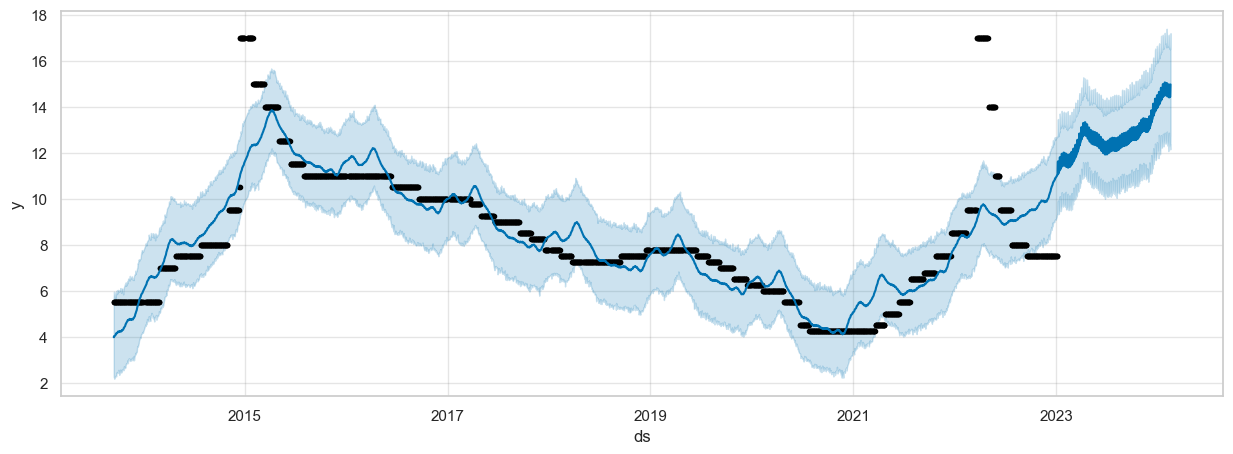

In [8]:
# Смотрим график прогноза
fig, ax = plt.subplots(1)
fig.set_figheight(5)
fig.set_figwidth(15)
fig = model_baseline.plot(forecast,ax=ax)
plt.show()

WARNING - (py.warnings._showwarnmsg) - c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()

WARNING - (py.warnings._showwarnmsg) - c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')

WARNING - (py.warnings._showwarnmsg) - c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:354: FutureWarn

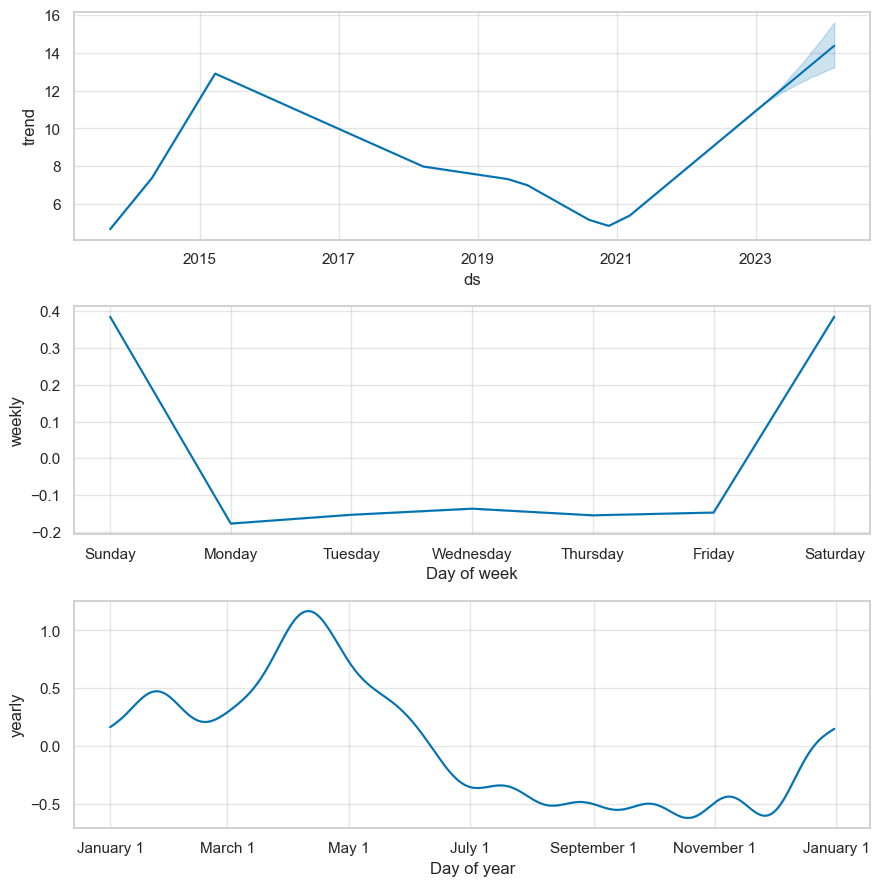

In [9]:
# Смотрим тренд, годовые и сезонные признаки
fig = model_baseline.plot_components(forecast)
plt.show()

## Сравнение фактов и прогнозов

In [10]:
# Создание df с прогнозом
df_test_forecast = model_baseline.predict(df_test)
df_test_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
403,2024-08-09,15.162880,12.265988,18.045677
404,2024-08-12,15.155577,12.344309,17.944326
405,2024-08-13,15.189057,12.453826,18.110018
406,2024-08-14,15.215961,12.241661,18.090442
407,2024-08-15,15.208843,12.474951,17.958618


WARNING - (py.warnings._showwarnmsg) - c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()

WARNING - (py.warnings._showwarnmsg) - c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',



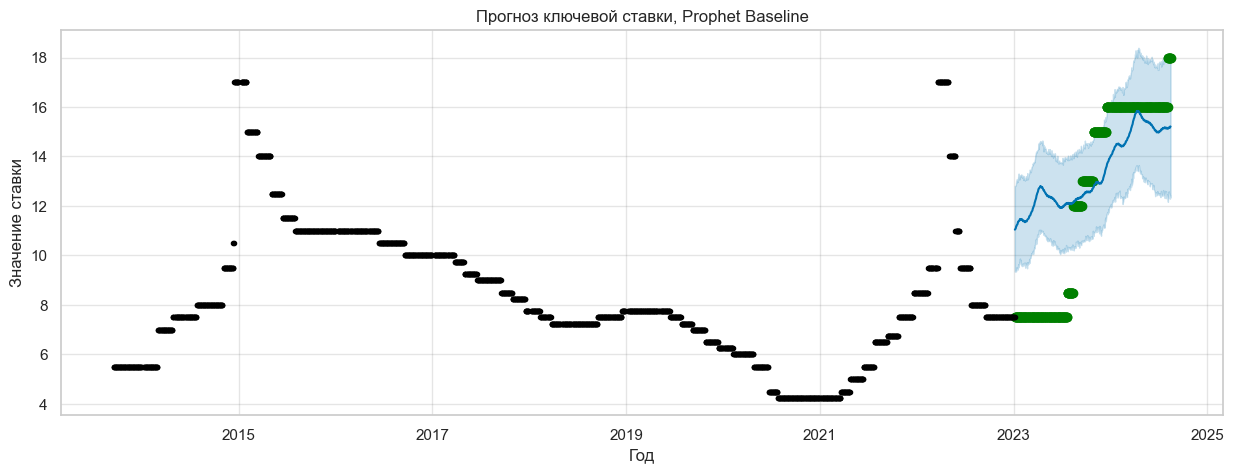

In [11]:
# Смотрим совпадение фактического курса с предсказанным курсом prophet baseline обученным на train
fig, ax = plt.subplots(figsize= (10, 5))

fig.set_figheight(5)
fig.set_figwidth(15)
predict = model_baseline.predict(df_test)
fig = model_baseline.plot(predict, ax=ax)
ax.scatter(df_test.ds, df_test['y'], color = 'g')
ax.set_title('Прогноз ключевой ставки, Prophet Baseline')
ax.set_ylabel('Значение ставки')
ax.set_xlabel('Год')
plt.show()

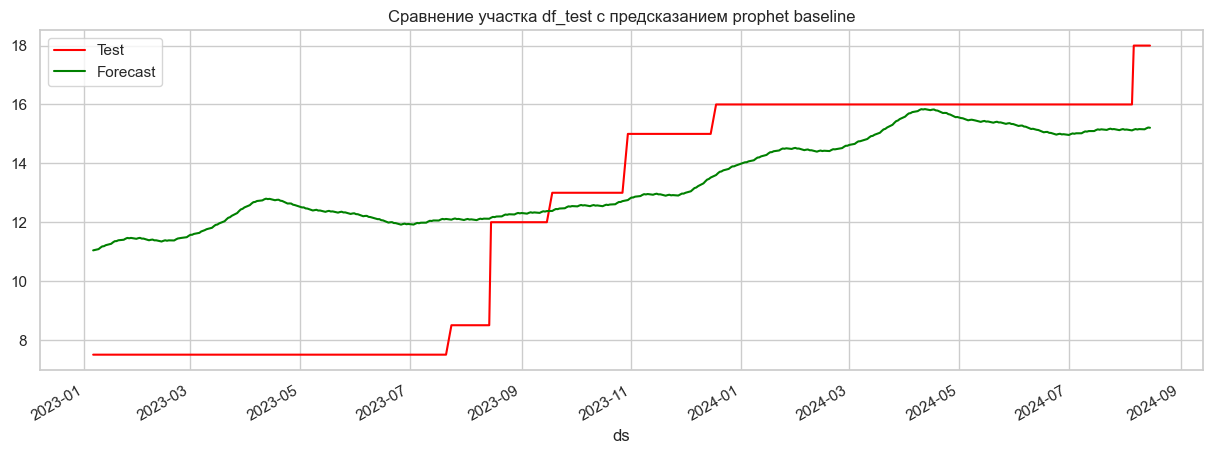

In [12]:
# Сравнение участка df_test с предсказанием prophet baseline
fig, ax = plt.subplots(figsize=(14,5))
fig.set_figheight(5)
fig.set_figwidth(15)
df_test.plot(kind='line',x='ds', y='y', color='red', label='Test', ax=ax)
df_test_forecast.plot(kind='line',x='ds',y='yhat', color='green',label='Forecast', ax=ax)
plt.title('Сравнение участка df_test с предсказанием prophet baseline')
plt.show()

In [13]:
# Просмотр метрик модели обученной на train
metrics = get_metrics(y_test=df_test['y'], y_pred=df_test_forecast['yhat'], name='Prophet_baseline')
metrics

,model,MAE,MAPE_%,MSE,RMSE
0,Prophet_baseline,2.321737,0.260319,8.394828,2.897383


Из приведенного выше графика мы видим, что существует разрыв в прогнозах и фактических данных. Поэтому нам нужно оптимизировать модель, добавив другие параметры, напрмиер, такие как праздники

# Prophet with holidays

In [14]:
# Создаем df праздников в РФ начиная с 2013 по сегодня
holiday = pd.DataFrame([])
for date, name in sorted(holidays.Russia(years=[2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024]).items()):
    new_row = pd.DataFrame({'ds': date, 'holiday': "RU-Holidays"}, index=[0])
    holiday = pd.concat([holiday, new_row], ignore_index=True)  

holiday['ds'] = pd.to_datetime(holiday['ds'], format='%Y-%m-%d', errors='ignore')

WARNING - (py.warnings._showwarnmsg) - C:\Users\myxa-\AppData\Local\Temp\ipykernel_2720\3236026523.py:7: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  holiday['ds'] = pd.to_datetime(holiday['ds'], format='%Y-%m-%d', errors='ignore')



In [15]:
# Тренировка модели с праздниками
model_with_holidays = Prophet(holidays=holiday)
model_with_holidays.fit(df_train)

00:07:48 - cmdstanpy - INFO - Chain [1] start processing
00:07:48 - cmdstanpy - INFO - Chain [1] done processing


In [16]:
# Создание df с прогнозом
future = model_with_holidays.make_future_dataframe(periods=pred_days, freq='D')
forecast = model_with_holidays.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
2717,2024-02-13,14.456183,12.311106,16.813352
2718,2024-02-14,14.479093,12.420242,16.695509
2719,2024-02-15,14.458520,12.372798,16.664022
2720,2024-02-16,14.474081,12.216936,16.681456
2721,2024-02-17,15.033760,13.038924,17.221104


WARNING - (py.warnings._showwarnmsg) - c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()

WARNING - (py.warnings._showwarnmsg) - c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',



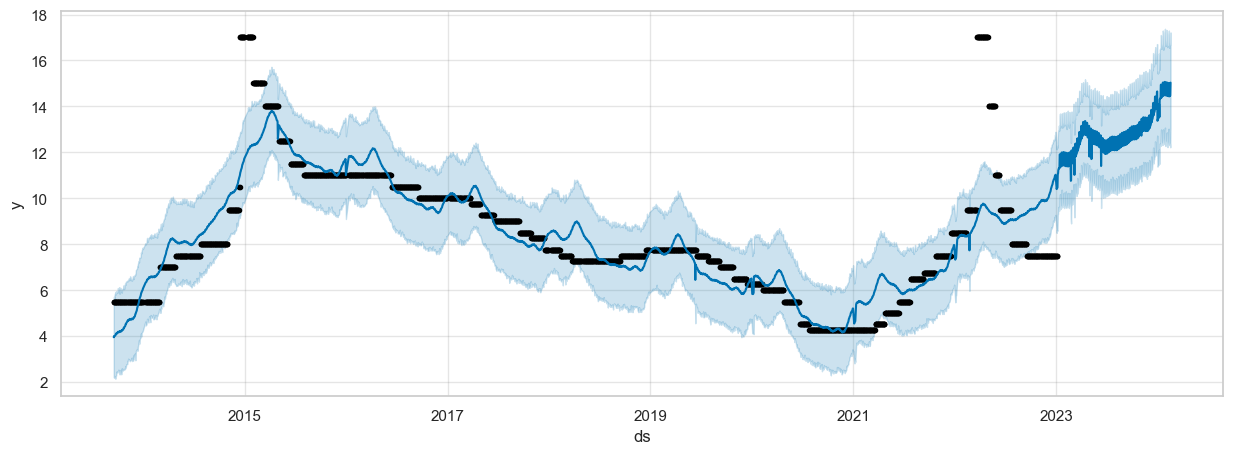

In [17]:
# Смотрим график прогноза с праздниками
fig, ax = plt.subplots(1)
fig.set_figheight(5)
fig.set_figwidth(15)
fig = model_with_holidays.plot(forecast,ax=ax)
plt.show()

WARNING - (py.warnings._showwarnmsg) - c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()

WARNING - (py.warnings._showwarnmsg) - c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')

WARNING - (py.warnings._showwarnmsg) - c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:354: FutureWarn

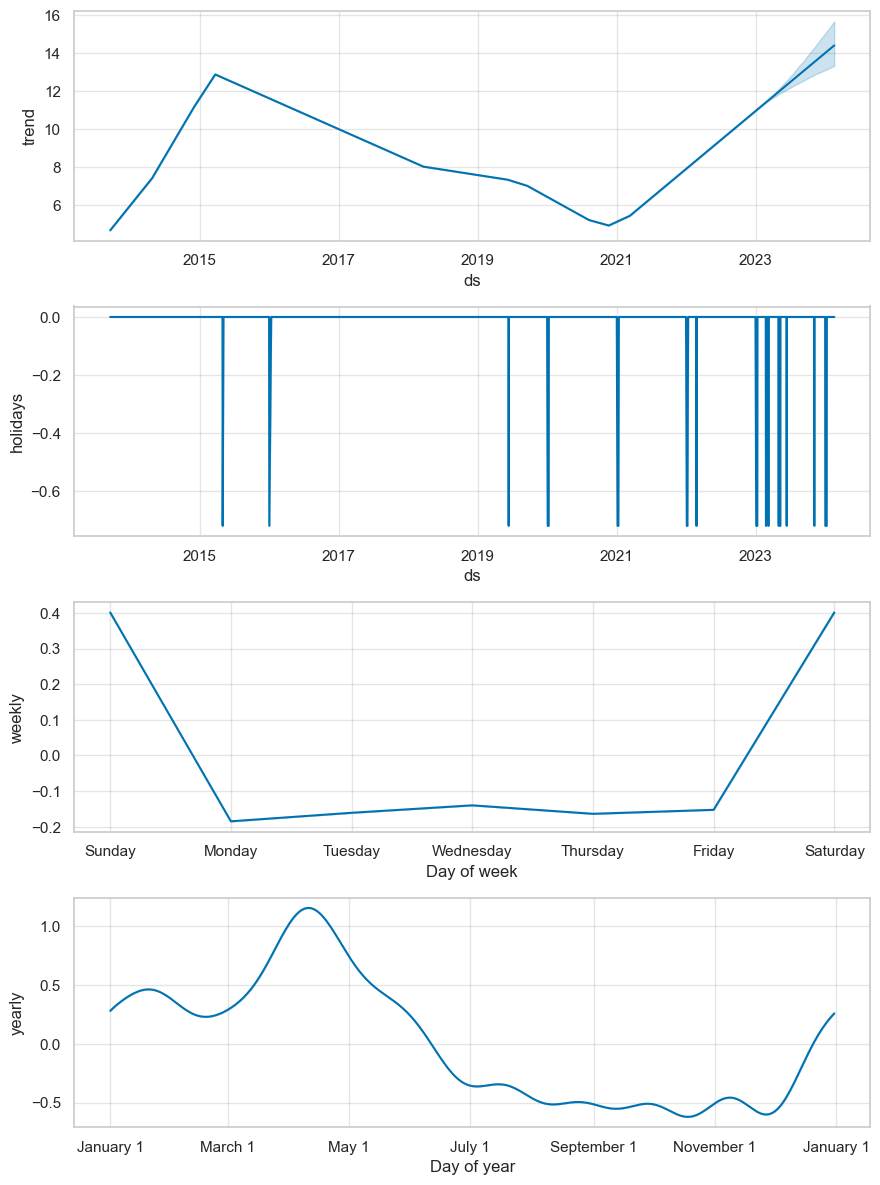

In [18]:
# Смотрим тренд, годовые и сезонные признаки обученной модели с праздниками
fig = model_with_holidays.plot_components(forecast)
plt.show()

## Сравнение фактов и прогнозов

In [19]:
# Создание df с прогнозом
df_test_forecast_holiday = model_with_holidays.predict(df_test)
df_test_forecast_holiday[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
403,2024-08-09,15.190160,12.350642,17.932923
404,2024-08-12,15.180454,12.295524,18.033557
405,2024-08-13,15.213469,12.325864,17.787404
406,2024-08-14,15.244143,12.246268,17.813830
407,2024-08-15,15.230640,12.261358,18.029351


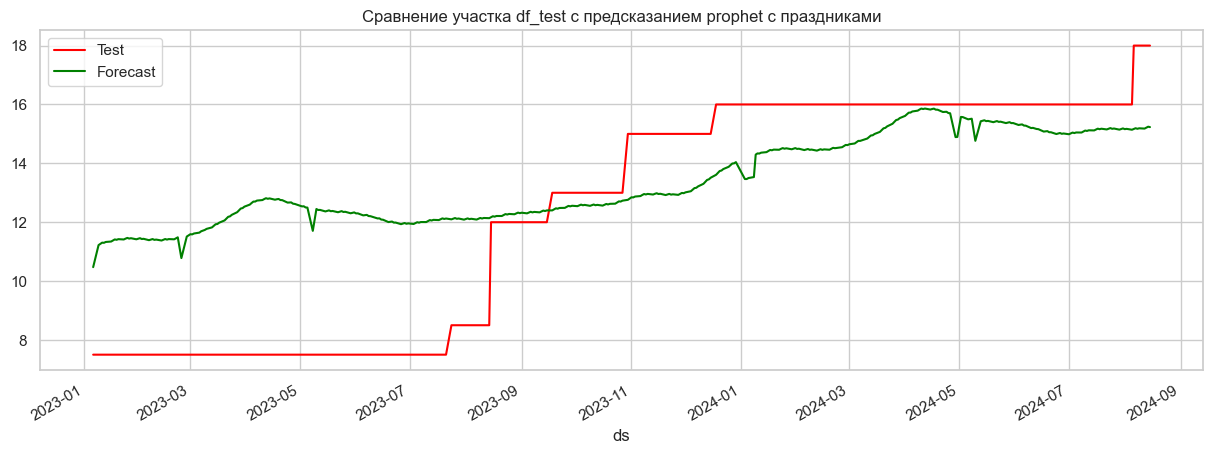

In [20]:
# Сравнение участка df_test с предсказанием prophet_with_holidays
fig, ax = plt.subplots(figsize=(14,5))
fig.set_figheight(5)
fig.set_figwidth(15)
df_test.plot(kind='line',x='ds', y='y', color='red', label='Test', ax=ax)
df_test_forecast_holiday.plot(kind='line',x='ds',y='yhat', color='green',label='Forecast', ax=ax)
plt.title('Сравнение участка df_test с предсказанием prophet с праздниками')
plt.show()

In [21]:
# Сравниваем метрики после добавления в модель праздников 
metrics = pd.concat([metrics, get_metrics(y_test=df_test['y'], y_pred=df_test_forecast_holiday['yhat'], name='Prophet_with_holidays')])
metrics

,model,MAE,MAPE_%,MSE,RMSE
0,Prophet_baseline,2.321737,0.260319,8.394828,2.897383
0,Prophet_with_holidays,2.323379,0.260700,8.435086,2.904322


Из метрик и графиков видим, что модель с праздниками показывает результаты немного изменились.

# Тюнинг тест модели

In [22]:
# Создание сетки параметров и подсчёт количества вариаций обучения
params_grid = {
    'changepoint_prior_scale': [0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.3, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1, 10], 
    'holidays_prior_scale': [0.01, 0.1, 1, 10],
    'seasonality_mode': ('multiplicative','additive')
}
grid = ParameterGrid(params_grid)
cnt = 0
for p in grid:
    cnt = cnt + 1

print('Количество моделей для обучения по сетке:', cnt)

Количество моделей для обучения по сетке: 672


In [23]:
"""Обучение тестовой модели по сетке параметров на df_train"""
# Создаем пустой DataFrame для сохранения метрик и параметров
model_grid_metrics = pd.DataFrame()
model_grid_parameters = pd.DataFrame(columns = ['Parameters'])

# Проходимся по сетке гиперпараметров
for p in tqdm(grid):
    
    # Обучаем Prophet по сетке гиперпараметров
    model_grid = Prophet(
        changepoint_prior_scale = p['changepoint_prior_scale'],
        seasonality_prior_scale = p['seasonality_prior_scale'],
        holidays_prior_scale = p['holidays_prior_scale'],
        seasonality_mode = p['seasonality_mode'],
        #changepoint_range = p['changepoint_range'],
        #holidays=holiday,
    )

    # Добавляем праздники в модель
    #model_grid.add_country_holidays(country_name='RU')

    # Обучаем модель
    model_grid.fit(df_train)

    # Создаем фрейм данных для предсказаний
    model_grid_future = model_grid.make_future_dataframe(periods=pred_days, freq='D', include_history=False)

    # Делаем предсказания
    model_grid_forecast = model_grid.predict(model_grid_future)

    # Вычисляем метрики и добавляем новую строку в df
    model_grid_metrics = pd.concat([model_grid_metrics, get_metrics(y_test=df_test['y'], y_pred=model_grid_forecast['yhat'], name='Prophet_with_grid ')])
    model_grid_parameters = pd.concat([model_grid_parameters, pd.DataFrame({'Parameters': [p]})], ignore_index=True)


  0%|          | 0/672 [00:00<?, ?it/s]00:07:51 - cmdstanpy - INFO - Chain [1] start processing
00:07:51 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 1/672 [00:00<05:49,  1.92it/s]00:07:51 - cmdstanpy - INFO - Chain [1] start processing
00:07:51 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 2/672 [00:01<05:48,  1.92it/s]00:07:52 - cmdstanpy - INFO - Chain [1] start processing
00:07:52 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 3/672 [00:01<05:40,  1.96it/s]00:07:52 - cmdstanpy - INFO - Chain [1] start processing
00:07:52 - cmdstanpy - INFO - Chain [1] done processing
  1%|          | 4/672 [00:02<05:42,  1.95it/s]00:07:53 - cmdstanpy - INFO - Chain [1] start processing
00:07:53 - cmdstanpy - INFO - Chain [1] done processing
  1%|          | 5/672 [00:02<05:41,  1.95it/s]00:07:53 - cmdstanpy - INFO - Chain [1] start processing
00:07:53 - cmdstanpy - INFO - Chain [1] done processing
  1%|          | 6/672 [00:03<05:41,  1.95it/s]0

In [24]:
# Сброс индексов для будущего объединения с df параметров сетки
model_grid_metrics = model_grid_metrics.reset_index(drop=True)

In [25]:
# Объединение DataFrame по столбцам
metrics_parameters_with_grid = pd.concat([model_grid_metrics, model_grid_parameters], axis=1)
metrics_parameters_with_grid

,model,MAE,MAPE_%,MSE,RMSE,Parameters
0,Prophet_with_grid,5.659897,0.382471,49.014486,7.001035,"{'changepoint_prior_scale': 0.001, 'holidays_p..."
1,Prophet_with_grid,5.596926,0.375184,48.826624,6.987605,"{'changepoint_prior_scale': 0.001, 'holidays_p..."
2,Prophet_with_grid,5.775760,0.388663,51.592290,7.182777,"{'changepoint_prior_scale': 0.001, 'holidays_p..."
3,Prophet_with_grid,5.630704,0.377952,49.303278,7.021629,"{'changepoint_prior_scale': 0.001, 'holidays_p..."
4,Prophet_with_grid,5.537628,0.370183,48.003951,6.928488,"{'changepoint_prior_scale': 0.001, 'holidays_p..."
...,...,...,...,...,...,...
667,Prophet_with_grid,15.625335,1.406444,537.536782,23.184839,"{'changepoint_prior_scale': 0.5, 'holidays_pri..."
668,Prophet_with_grid,3.114756,0.317565,12.083393,3.476118,"{'changepoint_prior_scale': 0.5, 'holidays_pri..."
669,Prophet_with_grid,3.150560,0.324114,12.592101,3.548535,"{'changepoint_prior_scale': 0.5, 'holidays_pri..."
670,Prophet_with_grid,3.158969,0.322841,12.521837,3.538621,"{'changepoint_prior_scale': 0.5, 'holidays_pri..."


In [26]:
# Сортировка по метрике
metrics_parameters_with_grid = metrics_parameters_with_grid.sort_values(by=['MAE'])
metrics_parameters_with_grid = metrics_parameters_with_grid.reset_index(drop=True)
metrics_parameters_with_grid.head()

,model,MAE,MAPE_%,MSE,RMSE,Parameters
0,Prophet_with_grid,3.062108,0.305491,11.229606,3.351060,"{'changepoint_prior_scale': 0.04, 'holidays_pr..."
1,Prophet_with_grid,3.062108,0.305491,11.229606,3.351060,"{'changepoint_prior_scale': 0.04, 'holidays_pr..."
2,Prophet_with_grid,3.062108,0.305491,11.229606,3.351060,"{'changepoint_prior_scale': 0.04, 'holidays_pr..."
3,Prophet_with_grid,3.062108,0.305491,11.229606,3.351060,"{'changepoint_prior_scale': 0.04, 'holidays_pr..."
4,Prophet_with_grid,3.062323,0.311301,11.645943,3.412615,"{'changepoint_prior_scale': 0.04, 'holidays_pr..."


## Лучшие параметры после обучения по сетке

In [27]:
# Сохранение в переменную лучших параметров после обучения по сетке
best_params = metrics_parameters_with_grid['Parameters'][0]

# Просмотр лучших параметров
best_params

{'changepoint_prior_scale': 0.04,
 'holidays_prior_scale': 0.01,
 'seasonality_mode': 'additive',
 'seasonality_prior_scale': 0.01}

In [28]:
# Обучение модели на лучших параметрах
final_test_model = Prophet(**best_params)
final_test_model.fit(df_train)

00:19:58 - cmdstanpy - INFO - Chain [1] start processing
00:19:58 - cmdstanpy - INFO - Chain [1] done processing


In [29]:
# Создание df с прогнозом
future = final_test_model.make_future_dataframe(periods=pred_days, freq='D')
forecast = final_test_model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
2717,2024-02-13,14.419408,12.505190,16.568400
2718,2024-02-14,14.435334,12.481170,16.450163
2719,2024-02-15,14.419021,12.411097,16.560637
2720,2024-02-16,14.429345,12.419905,16.530597
2721,2024-02-17,14.426754,12.518056,16.708594


WARNING - (py.warnings._showwarnmsg) - c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()

WARNING - (py.warnings._showwarnmsg) - c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')

WARNING - (py.warnings._showwarnmsg) - c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:354: FutureWarn

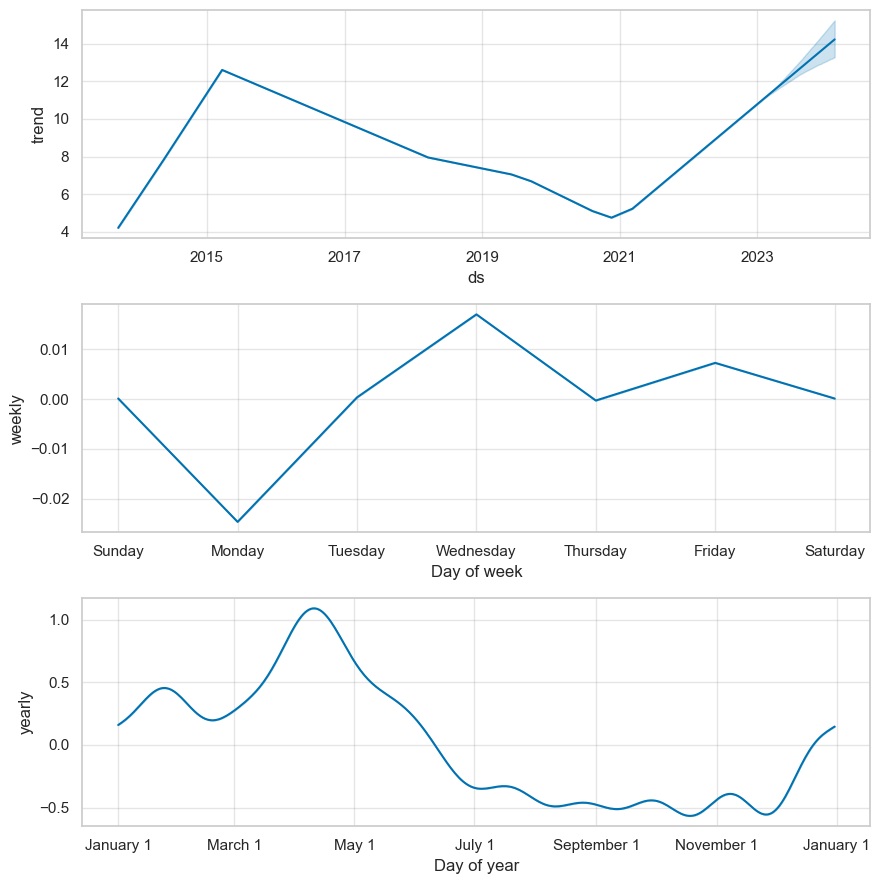

In [30]:
# Смотрим тренд, годовые и сезонные признаки
fig = final_test_model.plot_components(forecast)

WARNING - (py.warnings._showwarnmsg) - c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()

WARNING - (py.warnings._showwarnmsg) - c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',



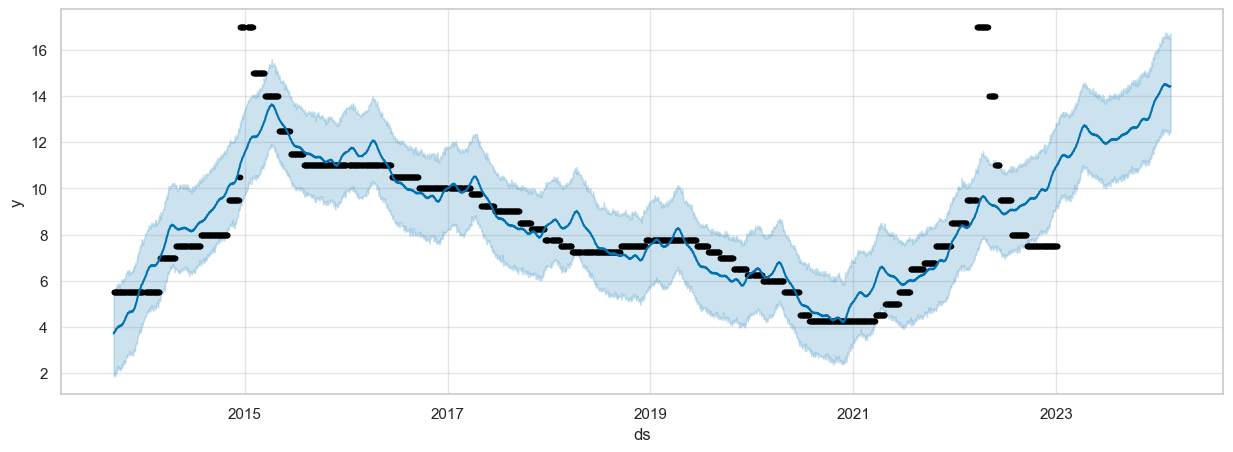

In [31]:
# Смотрим график прогноза после обучния на лучших параметрах
fig, ax = plt.subplots(1)
fig.set_figheight(5)
fig.set_figwidth(15)
fig = final_test_model.plot(forecast,ax=ax)
plt.show()

## Сравнение фактов и прогнозов

In [32]:
# Создание df с прогнозом
df_test_forecast_final = final_test_model.predict(df_test)
df_test_forecast_final[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
403,2024-08-09,15.203560,12.826494,17.531240
404,2024-08-12,15.195108,12.580101,17.564554
405,2024-08-13,15.229708,12.415161,17.778912
406,2024-08-14,15.256696,12.860059,17.747846
407,2024-08-15,15.250295,12.505485,17.783054


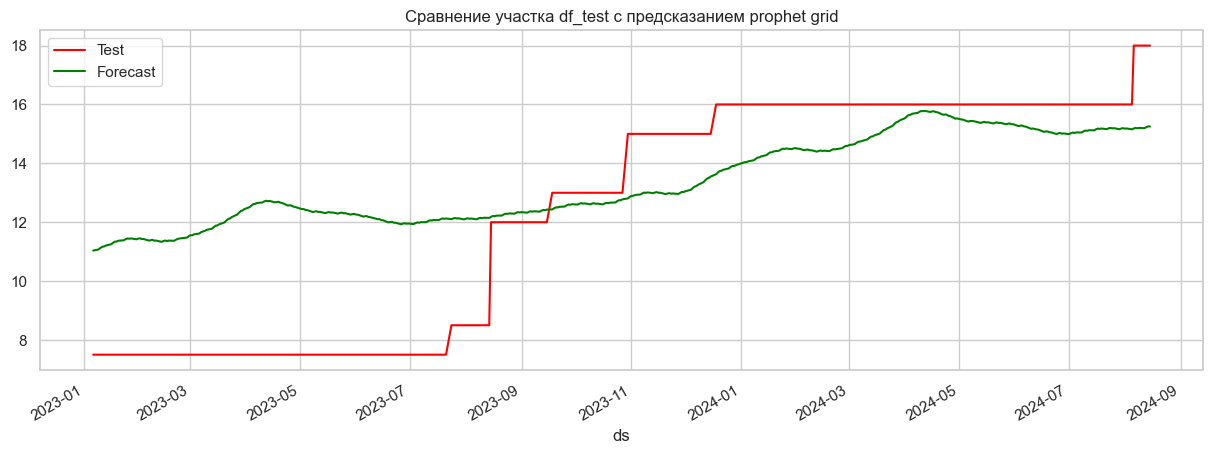

In [33]:
# Сравнение участка df_test с предсказанием prophet grid
fig, ax = plt.subplots(figsize=(14,5))
fig.set_figheight(5)
fig.set_figwidth(15)
df_test.plot(kind='line',x='ds', y='y', color='red', label='Test', ax=ax)
df_test_forecast_final.plot(kind='line',x='ds',y='yhat', color='green',label='Forecast', ax=ax)
plt.title('Сравнение участка df_test с предсказанием prophet grid')
plt.show()

In [34]:
# Сравниваем метрики после добавления в модель праздников 
metrics = pd.concat([metrics, get_metrics(y_test=df_test['y'], y_pred=df_test_forecast_final['yhat'], name='Prophet_with_grid')])
metrics

,model,MAE,MAPE_%,MSE,RMSE
0,Prophet_baseline,2.321737,0.260319,8.394828,2.897383
0,Prophet_with_holidays,2.323379,0.260700,8.435086,2.904322
0,Prophet_with_grid,2.310212,0.259073,8.303162,2.881521


In [35]:
# Сохранение модели в JSON файл
with open('../models/final_test_model.json', 'w') as fout:
    fout.write(model_to_json(final_test_model))

# Baseline NeuralProphet on df_train для проверки модели

In [36]:
# Обучение модели на df
NeuralProphet_bl = NeuralProphet()
NeuralProphet_bl.set_plotting_backend("plotly-static")
metricsnp = NeuralProphet_bl.fit(df_train)

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
WARNING - (py.warnings._showwarnmsg) - c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 97.191% of the data.
INFO - (NP.df_utils._infer_frequency) - Dataframe freq automatically defined as B
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 64
INFO - (NP.config.set_auto_batc

Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (37) is too small than the required number                     for the learning rate finder (234). The results might not be optimal.


Finding best initial lr:   0%|          | 0/234 [00:00<?, ?it/s]

WARNING - (py.warnings._showwarnmsg) - c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_lightning\utilities\data.py:78: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 64. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.

WARNING - (py.warnings._showwarnmsg) - c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_lightning\utilities\data.py:78: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 10. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.



Training: |          | 0/? [00:00<?, ?it/s]

In [37]:
# Создание df с прогнозом
future_np_bl = NeuralProphet_bl.make_future_dataframe(df_train, periods = pred_days, n_historic_predictions = True)
forecast_np_bl = NeuralProphet_bl.predict(df_test)
forecast_np_bl.tail()

WARNING - (py.warnings._showwarnmsg) - c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 97.191% of the data.
WARNING - (py.warnings._showwarnmsg) - c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

WARNING - (py.warnings._showwarnmsg) - c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning: Series.view is deprecated and will be remov

Predicting: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


,ds,y,yhat1,trend,season_yearly,season_weekly
403,2024-08-09,18.0,13.169708,9.915352,-0.255407,3.509765
404,2024-08-12,18.0,13.152449,9.934120,-0.268508,3.486837
405,2024-08-13,18.0,13.159808,9.940375,-0.272560,3.491993
406,2024-08-14,18.0,13.183439,9.946632,-0.276447,3.513253
407,2024-08-15,18.0,13.181760,9.952887,-0.280180,3.509054


WARNING - (NP.plotting.log_warning_deprecation_plotly) - DeprecationWarning: default plotting_backend will be changed to plotly in a future version. Switch to plotly by calling `m.set_plotting_backend('plotly')`.
WARNING - (py.warnings._showwarnmsg) - c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralprophet\plot_forecast_matplotlib.py:300: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst["ds"].dt.to_pydatetime()



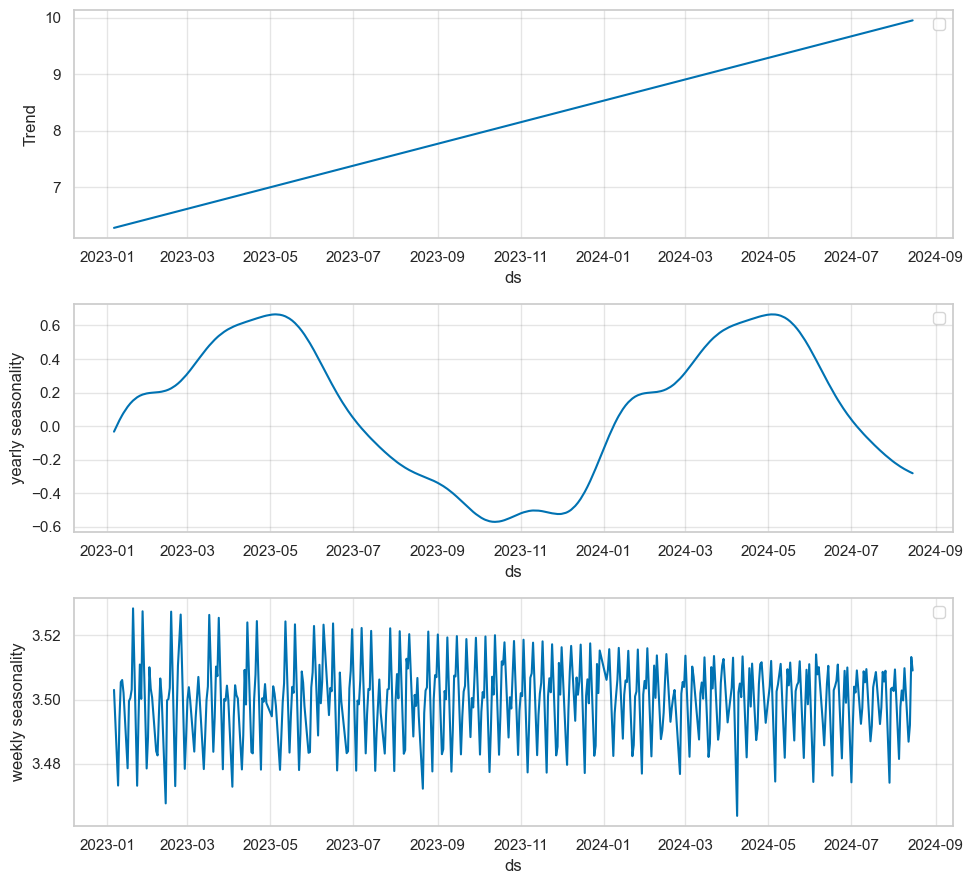

In [38]:
# Смотрим тренд, годовые и сезонные признаки
NeuralProphet_bl.plot_components(forecast_np_bl, plotting_backend="matplotlib")

In [39]:
# Смотрим график прогноза после обучения
fig = NeuralProphet_bl.plot(forecast_np_bl, ax=ax, plotting_backend="matplotlib")

WARNING - (NP.plotting.log_warning_deprecation_plotly) - DeprecationWarning: default plotting_backend will be changed to plotly in a future version. Switch to plotly by calling `m.set_plotting_backend('plotly')`.
WARNING - (py.warnings._showwarnmsg) - c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralprophet\plot_forecast_matplotlib.py:84: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ds = fcst["ds"].dt.to_pydatetime()



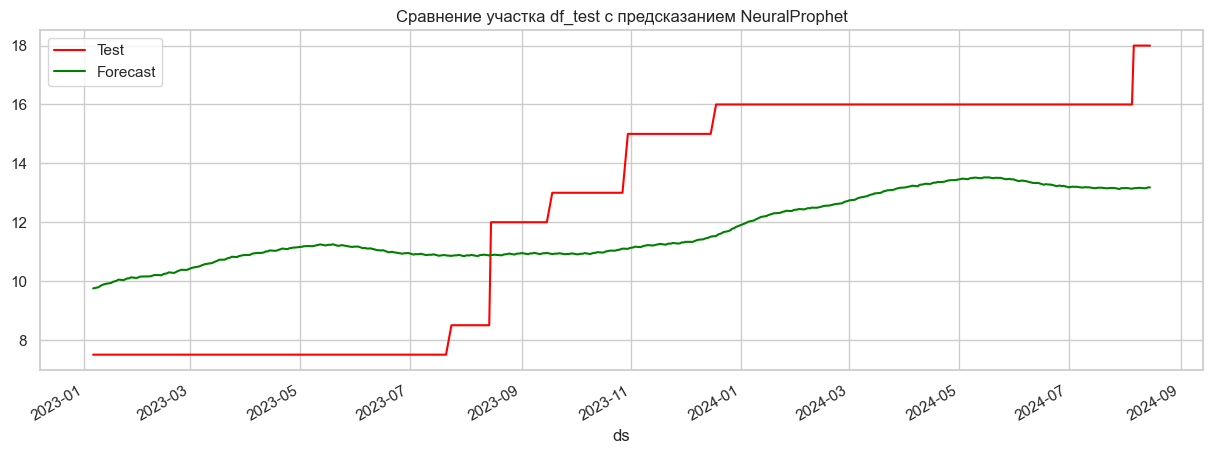

In [40]:
# Сравнение участка df_test с предсказанием prophet grid
fig, ax = plt.subplots(figsize=(14,5))
fig.set_figheight(5)
fig.set_figwidth(15)
df_test.plot(kind='line',x='ds', y='y', color='red', label='Test', ax=ax)
forecast_np_bl.plot(kind='line',x='ds',y='yhat1', color='green',label='Forecast', ax=ax)
plt.title('Сравнение участка df_test с предсказанием NeuralProphet')
plt.show()

In [41]:
# Сравниваем метрики после добавления NeuralProphet
metrics = pd.concat([metrics, get_metrics(y_test=df_test['y'], y_pred=forecast_np_bl['yhat1'], name='NeuralProphet')])
metrics

,model,MAE,MAPE_%,MSE,RMSE
0,Prophet_baseline,2.321737,0.260319,8.394828,2.897383
0,Prophet_with_holidays,2.323379,0.260700,8.435086,2.904322
0,Prophet_with_grid,2.310212,0.259073,8.303162,2.881521
0,NeuralProphet,2.996021,0.272980,9.578784,3.094961


# Обучение и прогнозирование курса ставки рефинансирования ЦБ РФ на полных данных

# Prophet baseline on df

In [42]:
# Обучение модели на df
prophet_bl = Prophet()
prophet_bl.fit(df)

00:20:31 - cmdstanpy - INFO - Chain [1] start processing
00:20:32 - cmdstanpy - INFO - Chain [1] done processing


In [43]:
# Создание df с прогнозом
future_bl = prophet_bl.make_future_dataframe(periods=pred_days_forecast, freq='D')
forecast_bl = prophet_bl.predict(future_bl)
forecast_bl[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
2897,2025-02-07,17.257928,15.138272,19.563757
2898,2025-02-08,18.033417,16.002813,20.132336
2899,2025-02-09,18.029709,15.725770,20.021799
2900,2025-02-10,17.235177,14.928809,19.441499
2901,2025-02-11,17.262239,14.847456,19.331232


WARNING - (py.warnings._showwarnmsg) - c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()

WARNING - (py.warnings._showwarnmsg) - c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',



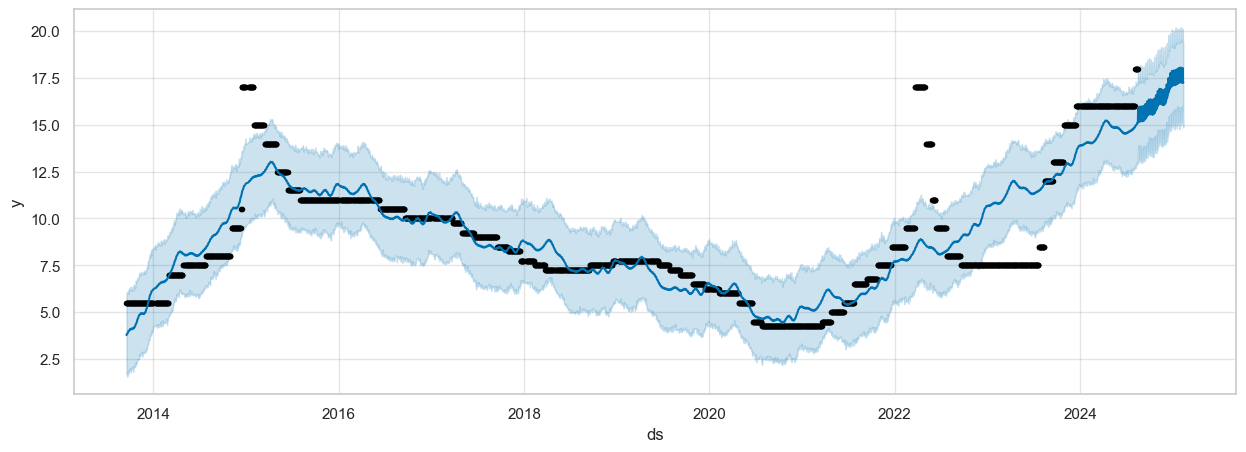

In [44]:
# Смотрим график прогноза
fig, ax = plt.subplots(1)
fig.set_figheight(5)
fig.set_figwidth(15)
fig = prophet_bl.plot(forecast_bl,ax=ax)
plt.show()

WARNING - (py.warnings._showwarnmsg) - c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()

WARNING - (py.warnings._showwarnmsg) - c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')

WARNING - (py.warnings._showwarnmsg) - c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:354: FutureWarn

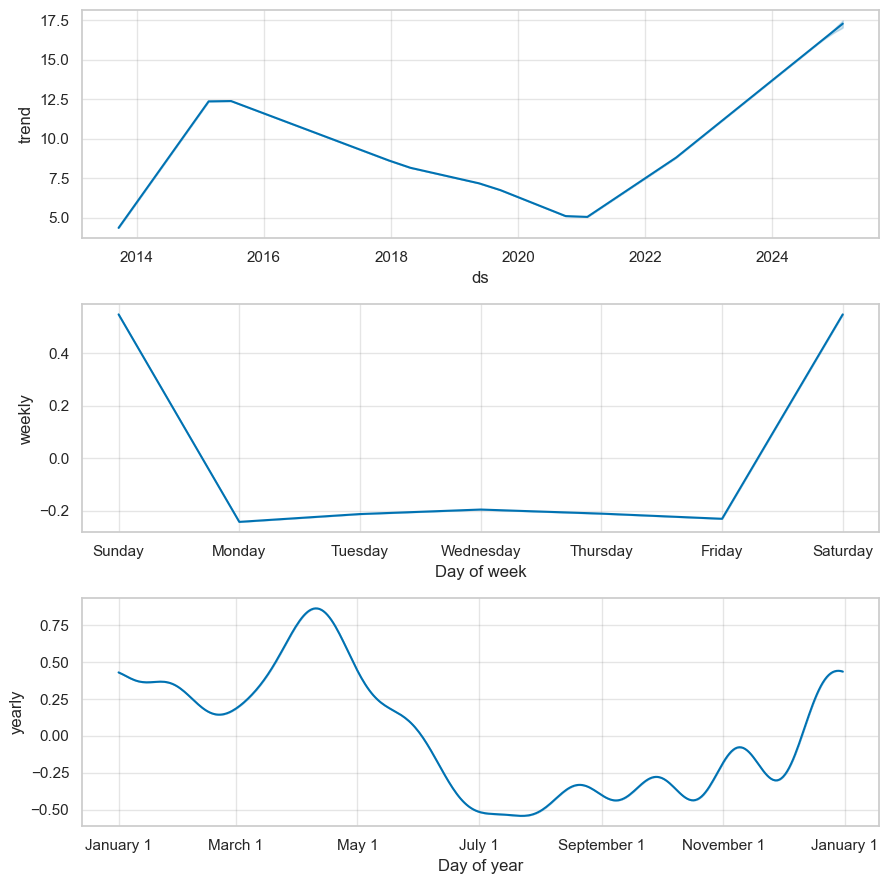

In [45]:
# Смотрим тренд, годовые и сезонные признаки
fig = prophet_bl.plot_components(forecast_bl)
plt.show()

# Prophet best params on df

In [46]:
# Обучение модели на df
final_test_model = Prophet()
final_test_model.fit(df)

00:20:34 - cmdstanpy - INFO - Chain [1] start processing
00:20:34 - cmdstanpy - INFO - Chain [1] done processing


In [47]:
# Создание df с прогнозом
future_ftm = final_test_model.make_future_dataframe(periods=pred_days_forecast, freq='D')
forecast_ftm = final_test_model.predict(future_ftm)
forecast_ftm[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
2897,2025-02-07,17.257928,15.109886,19.518123
2898,2025-02-08,18.033417,15.926325,20.278331
2899,2025-02-09,18.029709,15.876042,20.107928
2900,2025-02-10,17.235177,15.131347,19.587632
2901,2025-02-11,17.262239,14.970116,19.472364


WARNING - (py.warnings._showwarnmsg) - c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()



WARNING - (py.warnings._showwarnmsg) - c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',



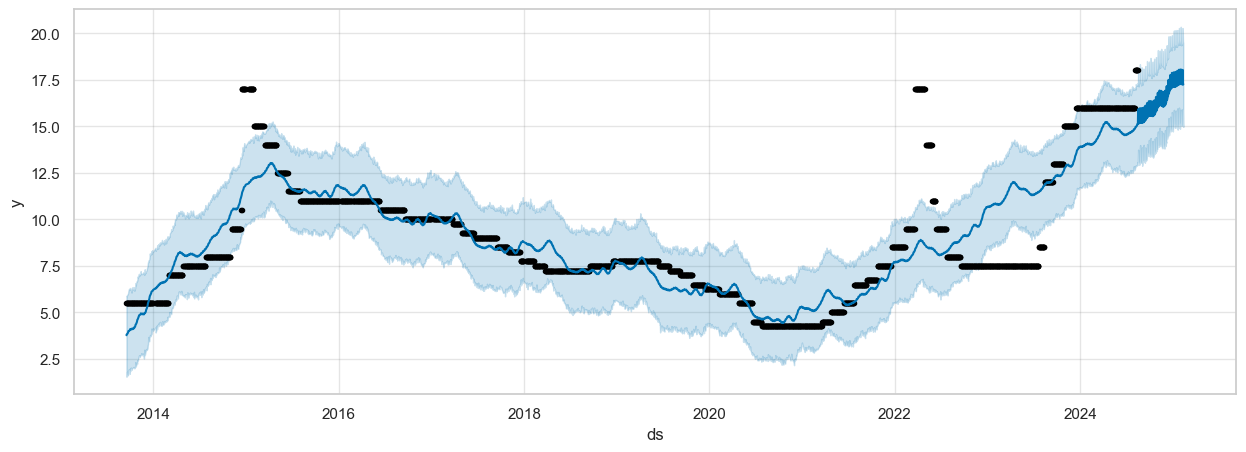

In [48]:
# Смотрим график прогноза
fig, ax = plt.subplots(1)
fig.set_figheight(5)
fig.set_figwidth(15)
fig = final_test_model.plot(forecast_ftm,ax=ax)
plt.show()

WARNING - (py.warnings._showwarnmsg) - c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()

WARNING - (py.warnings._showwarnmsg) - c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')

WARNING - (py.warnings._showwarnmsg) - c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:354: FutureWarn

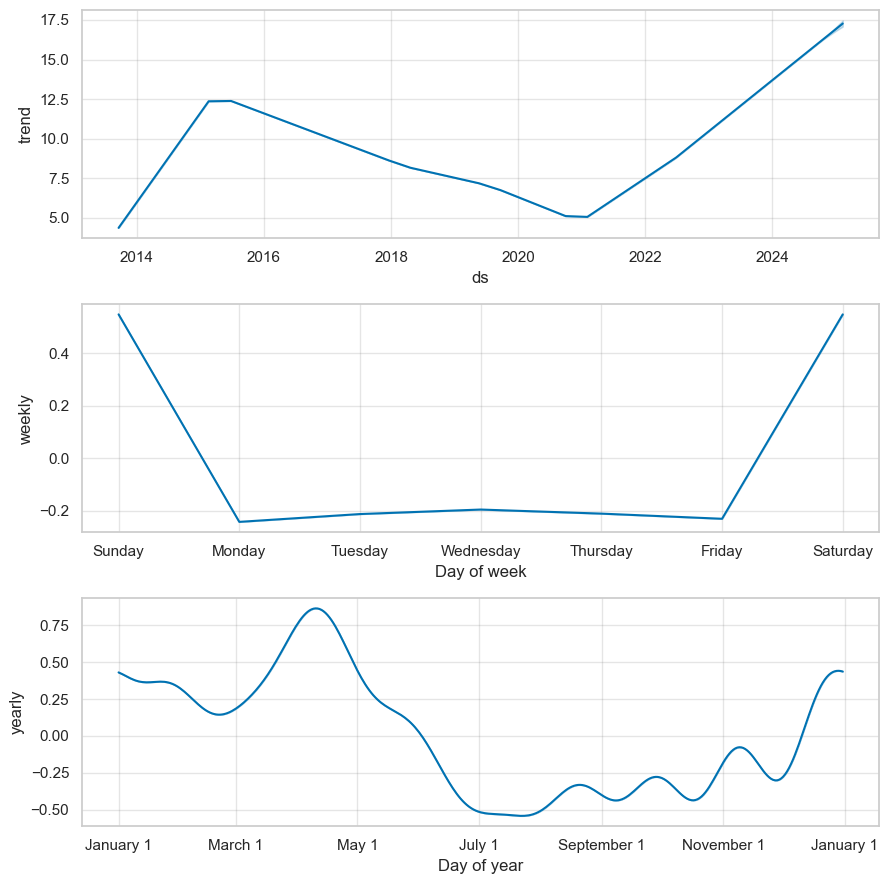

In [49]:
# Смотрим тренд, годовые и сезонные признаки
fig = prophet_bl.plot_components(forecast_ftm)
plt.show()

# NeuralProphet on df

In [50]:
# Обучение модели на df
NeuralProphet_df = NeuralProphet()
NeuralProphet_df.set_plotting_backend("plotly-static")
metricsnp = NeuralProphet_df.fit(df,)

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
WARNING - (py.warnings._showwarnmsg) - c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 97.208% of the data.
INFO - (NP.df_utils._infer_frequency) - Dataframe freq automatically defined as B
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 64
INFO - (NP.config.set_auto_batc

Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (43) is too small than the required number                     for the learning rate finder (236). The results might not be optimal.


Finding best initial lr:   0%|          | 0/236 [00:00<?, ?it/s]

WARNING - (py.warnings._showwarnmsg) - c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_lightning\utilities\data.py:78: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 34. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.



Training: |          | 0/? [00:00<?, ?it/s]

In [51]:
# Создание df с прогнозом
future_np = NeuralProphet_df.make_future_dataframe(df, periods = pred_days_forecast-104, n_historic_predictions = True)
forecast_np = NeuralProphet_df.predict(future_np)
forecast_np.tail()

WARNING - (py.warnings._showwarnmsg) - c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 97.208% of the data.
WARNING - (py.warnings._showwarnmsg) - c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

WARNING - (py.warnings._showwarnmsg) - c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning: Series.view is deprecated and will be remov

Predicting: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


,ds,y,yhat1,trend,season_yearly,season_weekly
2793,2024-11-25,NaN,16.325161,15.594071,-0.036976,0.768067
2794,2024-11-26,NaN,16.337093,15.602929,-0.036163,0.770327
2795,2024-11-27,NaN,16.370056,15.611787,-0.035088,0.793356
2796,2024-11-28,NaN,16.367973,15.620646,-0.033715,0.781045
2797,2024-11-29,NaN,16.350796,15.629503,-0.032018,0.753309


WARNING - (NP.plotting.log_warning_deprecation_plotly) - DeprecationWarning: default plotting_backend will be changed to plotly in a future version. Switch to plotly by calling `m.set_plotting_backend('plotly')`.
WARNING - (py.warnings._showwarnmsg) - c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralprophet\plot_forecast_matplotlib.py:300: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst["ds"].dt.to_pydatetime()



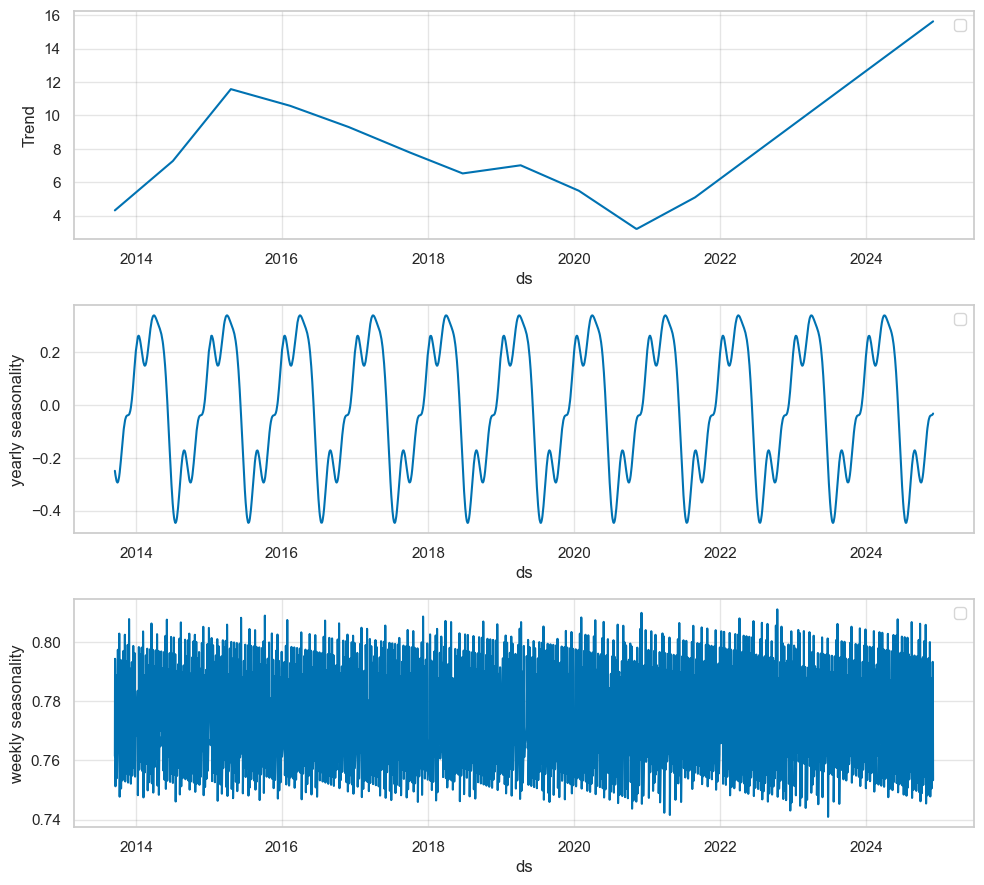

In [52]:
# Смотрим тренд, годовые и сезонные признаки
NeuralProphet_df.plot_components(forecast_np, plotting_backend="matplotlib")

WARNING - (NP.plotting.log_warning_deprecation_plotly) - DeprecationWarning: default plotting_backend will be changed to plotly in a future version. Switch to plotly by calling `m.set_plotting_backend('plotly')`.
WARNING - (py.warnings._showwarnmsg) - c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralprophet\plot_forecast_matplotlib.py:84: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ds = fcst["ds"].dt.to_pydatetime()



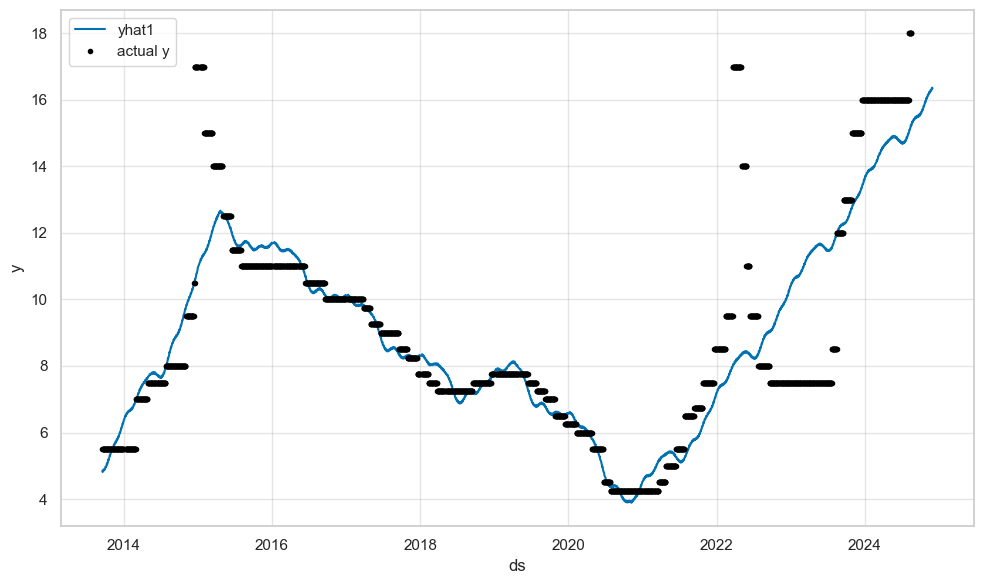

In [53]:
# Смотрим график прогноза
NeuralProphet_df.plot(forecast_np, plotting_backend="matplotlib")

# Сравнение прогнозов обученных моделей

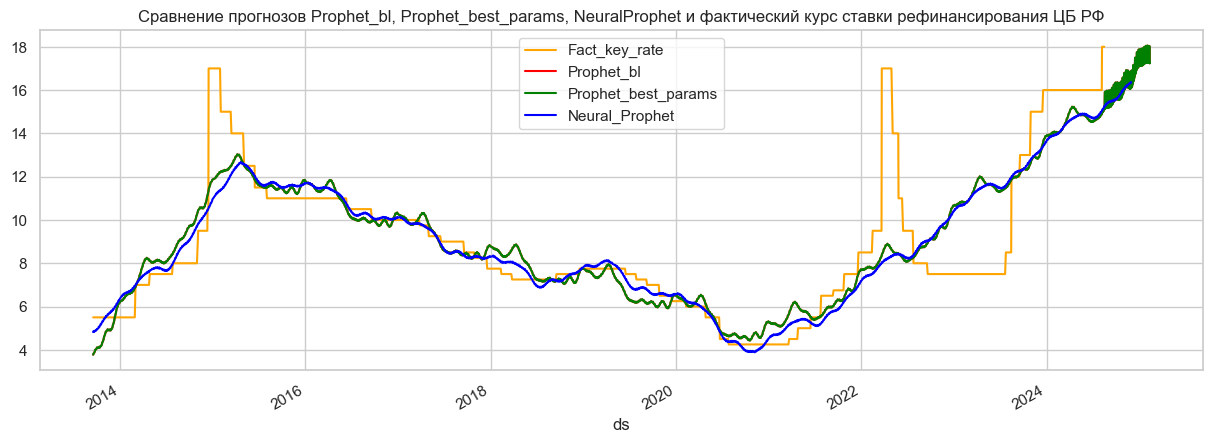

In [54]:
# Сравнение прогнозов Prophet_bl, Prophet_best_params, NeuralProphet и фактический курс ставки рефинансирования ЦБ РФ
fig, ax = plt.subplots(figsize=(14,5))
fig.set_figheight(5)
fig.set_figwidth(15)
df.plot(kind='line',x='ds', y='y', color='orange', label='Fact_key_rate', ax=ax)
forecast_bl.plot(kind='line', x='ds', y='yhat', color='red', label='Prophet_bl', ax=ax)
forecast_ftm.plot(kind='line', x='ds', y='yhat', color='green', label='Prophet_best_params', ax=ax)
forecast_np.plot(kind='line', x='ds', y='yhat1', color='blue', label='Neural_Prophet', ax=ax)
plt.title('Сравнение прогнозов Prophet_bl, Prophet_best_params, NeuralProphet и фактический курс ставки рефинансирования ЦБ РФ')
plt.show()

Исходя из графиков, видно что Prophet с лучшими параметрами, лучше предсказал курс ключевой ставки ЦБ РФ.